In [2]:
import sys
sys.path.append("..")
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
font = {'family' : 'STIXGeneral',
        'size'   : 12}
matplotlib.rc('font', **font)
from sklearn.metrics import r2_score

import occrx
from occrx.framestreamer import FrameStreamer
from occrx.occParams import OCCSystemParams, OCCTestParams, OCCTxParams, OCCRxParams, OCCChannelParams
from occscripts.occscriptutils import Circle, Rectangle
from occscripts.testdetection import DetectionResults
from occscripts.testcalibration import CalibrationResults
from occscripts.testdecoding import DecodingResults

def transformCirclePoints(circle, radius):
    return Circle((radius,radius),circle.radius)
def translatePoints(oldCirclePoint,newCirclePoint,points):
    dx,dy = oldCirclePoint - newCirclePoint
    return (points[0]-dx, points[1]-dy)
def drawCircleMatrix(width,height,circle):
    xx, yy = np.mgrid[:height, :width]
    circleMatrix = (xx - circle.centroid[1]) ** 2 + (yy - circle.centroid[0]) ** 2
    return np.repeat(np.expand_dims(((np.logical_and(circleMatrix < circle.radius ** 2, circleMatrix > 0)).astype(np.int))*255,axis=2),3,axis=2)

tests = {
    "detection":"detectiontests",
    "calibration":"calibration",
    "decoding":"decoding"
}
def getTestFolder(baseFolder,frequency,distance,testType,testNumber):
    return baseFolder+'/f{}_s1920.0x1080.0_fps30.0_g75.0_wb6500_exp3.0_distance{}cm'.format(frequency,distance)\
                        +'/{}/test{}'.format(tests[testType],testNumber)

def getParamsForTest(testFolder):
    
    occSystemParams = OCCSystemParams()
    occTestParams = OCCTestParams()
    occDetetionCircle = Circle()
    occDetectionResults = DetectionResults()
    occCalibrationResults = CalibrationResults()
    occDecodingResults = DecodingResults()
    
    try:
        with open(testFolder+"/occsytemparams.json") as json_file:
            occSystemParams.initFromJSON(json.load(json_file))
    except IOError:
        occSystemParams = None
    try:
        with open(testFolder+"/occtestparams.json") as json_file:
            occTestParams.initFromJSON(json.load(json_file))
    except IOError:
        occTestParams = None
    try:
        with open(testFolder+"/circle.json") as json_file:
            occDetetionCircle.initFromJSON(json.load(json_file))
    except IOError:
        occTestParams = None
    try:
        with open(testFolder+"/detectionresults.json") as json_file:
            occDetectionResults.initFromJSON(json.load(json_file))
    except IOError:
        occDetectionResults = None
    try:
        with open(testFolder+"/calibrationresults.json") as json_file:
            occCalibrationResults.initFromJSON(json.load(json_file))
    except IOError:
        occCalibrationResults = None
    try:
        with open(testFolder+"/decodingresults.json") as json_file:
            occDecodingResults.initFromJSON(json.load(json_file))
    except IOError:
        occDecodingResults = None
    
    return occSystemParams,occTestParams,occDetetionCircle,occDetectionResults,occCalibrationResults,occDecodingResults


In [3]:
baseFolder = '../videos/validation2/f3240'
decodingTestNumber = 1
frequency = 3240
distance = 55
testFolder = getTestFolder(baseFolder,frequency,distance,"decoding",decodingTestNumber)
errorNumber = 1
errorFile = testFolder+'/error/error{}.jpg'.format(errorNumber)

occSystemParams,\
occTestParams,\
occDetectionCircle,\
occDetectionResults,\
occCalibrationResults,\
occDecodingResults = getParamsForTest(testFolder)

streamer = FrameStreamer(errorFile, isRealTime=False)
isGrabbed, frame = streamer.grabFrame()
frame = frame**(1/1.8)
plt.imshow(frame)

The frame streamer is not available. Trying again (0)
The frame streamer is not available. Trying again (1)
The frame streamer is not available. Trying again (2)


TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'float'

[[976 445]
 [991 610]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[ROI] Max value: 0.0
[ROI] Max value True: True
[ROI] Threshold value: 0


ValueError: not enough values to unpack (expected 7, got 6)

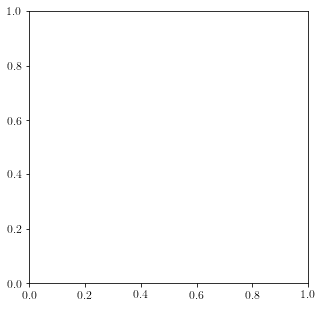

In [38]:
roiPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                      11)
packetPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                     5)
syncPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.syncPattern,
                                                     5)
calibrationPattern = occrx.templates.generateFinalPattern(occSystemParams.occTxParams.patterns.roiPattern,
                                                          10)
roiTemplate = occrx.templates.generateTemplate(pattern=roiPattern,
                                                   rowHeight=occSystemParams.occRxParams.rowHeight,
                                                   columnHeight=15)
packetTemplate = occrx.templates.generateTemplate(pattern=packetPattern,
                                                  rowHeight=occSystemParams.occRxParams.rowHeight,
                                                  columnHeight=15)
syncTemplate = occrx.templates.generateTemplate(pattern=syncPattern,
                                                  rowHeight=occSystemParams.occRxParams.rowHeight,
                                                  columnHeight=15)
roiHeight = roiTemplate.shape[0]
calibrationMeasurements = np.zeros((roiHeight, 3, 3))
calibrationFitting = np.zeros((roiHeight,3,3))

height = occSystemParams.occRxParams.rowHeight*11
width = 5
rectangle = Rectangle(topLeftCornerPoint=(0,0),width=width,height=height)

fig = plt.figure(figsize=(5,5))
ajustAx = fig.add_subplot(1, 1, 1)

droi = occCalibrationResults.roiPoint
print(droi)
print(frame)
roiFrame = frame[droi[0][1]:droi[1][1], droi[0][0]:droi[1][0], :].copy()

isGreater,topLeft,bottom_right,maxVal,minPoint,minVal,roi=occrx.detector.detectRoi(roiFrame, syncTemplate, threshold=0)
frameCopy = frame.copy()

cv2.rectangle(frameCopy,droi[0],droi[1],(1,1,1),3)
cv2.rectangle(frameCopy,(droi[0][0],droi[0][1]+topLeft[1]),(droi[0][0]+15,droi[0][1]+topLeft[1]+occSystemParams.occRxParams.rowHeight*5),(0,1,1),3)
count = 0    
ajustAx[0,0].title.set_text("Frame n+{}".format(count))
ajustAx[0,0].imshow(frameCopy[300:300+375, 750:750+375]**(1/1.8))
plt.show()

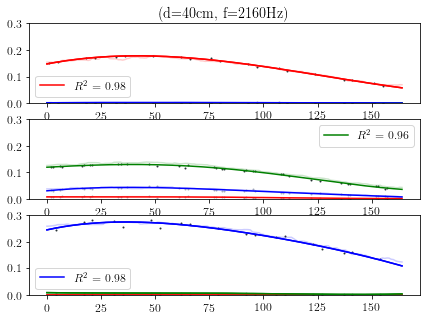

In [20]:
##Calibration
fig, ajustAx = plt.subplots(3, 1, figsize=(7,5),sharey=True)
calibrationMeasurements = occCalibrationResults.measuredValues
x = np.arange(calibrationMeasurements.shape[0])

calibrationFitting = occCalibrationResults.predictedValues
realValues = occCalibrationResults.realValues
ajustAx[0].set_ylim([0,0.2])
ajustAx[1].set_ylim([0,0.15])
ajustAx[2].set_ylim([0,0.3])

ajustAx[0].title.set_text('(d={}cm, f={}Hz)'.format(distance, frequency))
ajustAx[0].plot(realValues[:, 0,0]+0.01, c='r',alpha=0.2)
ajustAx[0].plot(realValues[:, 1,0], c='g',alpha=0.2)
ajustAx[0].plot(realValues[:, 2,0], c='b',alpha=0.2)

r2Red = r2_score(realValues[:, 0,0]+0.01,calibrationFitting[:, 0,0])
r2Green = r2_score(realValues[:, 1,0],calibrationFitting[:, 1,0])
r2Blue = r2_score(realValues[:, 2,0],calibrationFitting[:, 2,0])

ajustAx[0].scatter(x,calibrationMeasurements[:, 0,0], c='#293336',s=1)
ajustAx[0].scatter(x,calibrationMeasurements[:, 1,0], c='#a7adba',s=1)
ajustAx[0].scatter(x,calibrationMeasurements[:, 2,0], c='#a7adba',s=1)

ajustAx[0].plot(calibrationFitting[:, 0,0], c='r', label = '$R^2$ = %0.2f' % r2Red)
ajustAx[0].plot(calibrationFitting[:, 1,0], c='g')
ajustAx[0].plot(calibrationFitting[:, 2,0], c='b')
ajustAx[0].legend(loc = 'lower left')

ajustAx[0].plot(calibrationFitting[:, 0,0], c='r')
ajustAx[0].plot(calibrationFitting[:, 1,0], c='g')
ajustAx[0].plot(calibrationFitting[:, 2,0], c='b')

ajustAx[1].plot(realValues[:, 0,1], c='r',alpha=0.2)
ajustAx[1].plot(realValues[:, 1,1], c='g',alpha=0.2)
ajustAx[1].plot(realValues[:, 2,1], c='b',alpha=0.2)

r2Red = r2_score(realValues[:, 0,1],calibrationFitting[:, 0,1])
r2Green = r2_score(realValues[:, 1,1],calibrationFitting[:, 1,1])
r2Blue = r2_score(realValues[:, 2,1],calibrationFitting[:, 2,1])
ajustAx[1].scatter(x,calibrationMeasurements[:, 0,1], c='#a7adba',s=1)
ajustAx[1].scatter(x,calibrationMeasurements[:, 1,1], c='#293336',s=1)
ajustAx[1].scatter(x,calibrationMeasurements[:, 2,1], c='#a7adba',s=1)

ajustAx[1].plot(calibrationFitting[:, 0,1], c='r')
ajustAx[1].plot(calibrationFitting[:, 1,1], c='g', label = '$R^2$ = %0.2f' % r2Green)
ajustAx[1].plot(calibrationFitting[:, 2,1], c='b')
ajustAx[1].legend(loc = 'upper right')

ajustAx[2].plot(realValues[:, 0,2], c='r',alpha=0.2)
ajustAx[2].plot(realValues[:, 1,2], c='g',alpha=0.2)
ajustAx[2].plot(realValues[:, 2,2], c='b',alpha=0.2)
r2Red = r2_score(realValues[:, 0,2],calibrationFitting[:, 0,2])
r2Green = r2_score(realValues[:, 1,2],calibrationFitting[:, 1,2])
r2Blue = r2_score(realValues[:, 2,2],calibrationFitting[:, 2,2])
ajustAx[2].scatter(x,calibrationMeasurements[:, 0,2], c='#a7adba',s=1)
ajustAx[2].scatter(x,calibrationMeasurements[:, 1,2], c='#a7adba',s=1)
ajustAx[2].scatter(x,calibrationMeasurements[:, 2,2], c='#293336',s=1)

ajustAx[2].plot(calibrationFitting[:, 0,2], c='r')
ajustAx[2].plot(calibrationFitting[:, 1,2], c='g')
ajustAx[2].plot(calibrationFitting[:, 2,2], c='b')

ajustAx[2].plot(calibrationFitting[:, 0,2], c='r')
ajustAx[2].plot(calibrationFitting[:, 1,2], c='g')
ajustAx[2].plot(calibrationFitting[:, 2,2], c='b', label = '$R^2$ = %0.2f' % r2Blue)
ajustAx[2].legend(loc = 'lower left')
plt.show()